# LSTM Modelling 

In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

2023-05-10 10:11:46.864630: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 10:11:46.976949: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-10 10:11:46.978276: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-10 10:11:47.967989: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Refactor

In [2]:
dataset = pd.read_csv("./StationDateDatasets/datasetStationDate.csv").drop(columns=["Unnamed: 0"])

In [10]:
trips = pd.read_csv("./CSVFiles/datatrips.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips = trips.drop(columns=["DateEnd"])
trips["Day"] = day
trips["Year"] = year

In [11]:
new_data = pd.DataFrame({"Holiday": [], "Weekday": [], "Workingday": [], "WeatherSituation": [], "Temp": [], "ATemp": [], "Humidity": [], "Windspeed": []})

for data in dataset.values:
    hour = data[0]
    station = data[1]
    day = data[3]
    year = data[4]

    df = trips.loc[(trips["StationEnd"] == station) & (trips["Day"] == day) & (trips["Year"] == year) & (trips["Hour"] == hour)].values[0][6:-1]
    new_data.loc[len(new_data)] = df

dataset = dataset.join(new_data)

In [12]:
dataset.to_csv("./StationDateDatasets/datasetStationDate.csv")

## Correlation Features

In [13]:
def featureSelect_dataframe(X, y, criteria, k):

    # initialize our function/method
    reg = SelectKBest(criteria, k=k).fit(X,y)
    
    # transform after creating the reg (so we can use getsupport)
    X_transformed = reg.transform(X)

    # filter down X based on kept columns
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    # return that dataframe
    return X, reg.scores_

X = dataset[[col for col in dataset.columns if "Count" not in col]]
y = dataset['Count']

new_x_data = []

# F-value between label/feature for regression tasks.
New_X, scoresX = featureSelect_dataframe(X, y, f_regression, 11)
new_x_data_1 = {list(X.columns)[x]:scoresX[x] for x in range(0,len(list(X.columns)))}
pprint(sorted(new_x_data_1.items(), key=lambda x:x[1], reverse=True))

[('Temp', 7854.233184039789),
 ('ATemp', 7706.912809130377),
 ('Year', 5350.628642028699),
 ('Humidity', 5196.287790444266),
 ('Hour', 2591.040359724638),
 ('WeatherSituation', 1576.8091838740354),
 ('Windspeed', 261.06541187993037),
 ('Day', 225.13003715150458),
 ('StationEnd', 215.19085620330532),
 ('Workingday', 72.2059928262909),
 ('Holiday', 60.46833284115195),
 ('Weekday', 48.945415173314345)]


## LSTM

In [28]:
epochs = 1
batch_size = 1
verbose = 2

MSE = [4.218448305130005, 4.1836066246032715, 6.3516003608703615, 6.35099196434021, 6.350759696960449, 6.349380588531494]

### Method 0
Input: c(t), StationEnd

Output: c(t+1)

In [16]:
cols = ["StationEnd", "Count", "Count1", "Count1week"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/5


2023-05-10 15:12:29.319651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 15:12:29.320629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 15:12:29.321261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

KeyboardInterrupt: 

Text(0.5, 0, 'Methods')

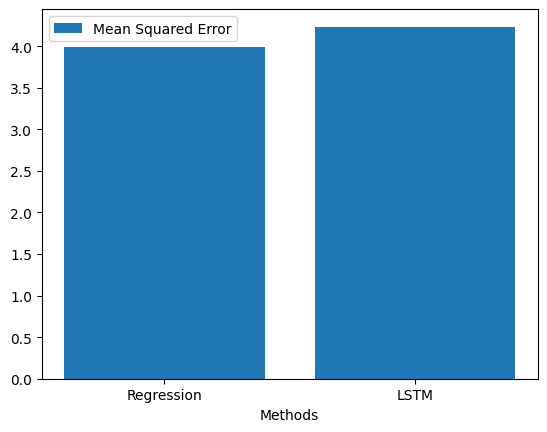

In [ ]:
plt.bar(["Regression", "LSTM"], [3.9857409829075623, 4.233919239044189])
plt.legend(["Mean Squared Error"])
plt.xlabel("Methods")

### Method 1
Input: c(t), StationEnd, Temp

Output: c(t+1)

In [17]:
cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

MSE.append(mean)

Epoch 1/5


2023-05-10 15:12:37.446684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 15:12:37.447635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 15:12:37.448260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 151s - loss: 4.3568 - accuracy: 0.3337 - 151s/epoch - 823us/step
Epoch 2/5
183062/183062 - 149s - loss: 4.1975 - accuracy: 0.3342 - 149s/epoch - 814us/step
Epoch 3/5
183062/183062 - 147s - loss: 4.1810 - accuracy: 0.3342 - 147s/epoch - 806us/step
Epoch 4/5
183062/183062 - 140s - loss: 4.1765 - accuracy: 0.3342 - 140s/epoch - 767us/step
Epoch 5/5
183062/183062 - 137s - loss: 4.1761 - accuracy: 0.3342 - 137s/epoch - 746us/step


2023-05-10 15:24:41.824515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 15:24:41.825644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 15:24:41.826342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5
183062/183062 - 138s - loss: 4.1755 - accuracy: 0.3341 - 138s/epoch - 754us/step
Epoch 2/5
183062/183062 - 138s - loss: 4.1770 - accuracy: 0.3341 - 138s/epoch - 752us/step
Epoch 3/5
183062/183062 - 137s - loss: 4.1708 - accuracy: 0.3341 - 137s/epoch - 747us/step
Epoch 4/5
183062/183062 - 139s - loss: 4.1698 - accuracy: 0.3341 - 139s/epoch - 758us/step
Epoch 5/5
183062/183062 - 143s - loss: 4.1719 - accuracy: 0.3341 - 143s/epoch - 783us/step
Epoch 1/5
183062/183062 - 146s - loss: 4.1815 - accuracy: 0.3340 - 146s/epoch - 800us/step
Epoch 2/5
183062/183062 - 146s - loss: 4.1821 - accuracy: 0.3340 - 146s/epoch - 799us/step
Epoch 3/5
183062/183062 - 146s - loss: 4.1822 - accuracy: 0.3340 - 146s/epoch - 799us/step
Epoch 4/5
183062/183062 - 146s - loss: 4.1789 - accuracy: 0.3340 - 146s/epoch - 799us/step
Epoch 5/5
183062/183062 - 148s - loss: 4.1781 - accuracy: 0.3340 - 148s/epoch - 808us/step
Epoch 1/5
183063/183063 - 146s - loss: 4.1508 - accuracy: 0.3341 - 146s/epoch - 799us/step

### Method 2
Input: c(t), StationEnd, Temp, ATemp

Output: c(t+1)

In [18]:
cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

MSE.append(mean)

Epoch 1/5


2023-05-10 17:22:18.735639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 17:22:18.736455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 17:22:18.737231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 165s - loss: 4.3545 - accuracy: 0.3334 - 165s/epoch - 903us/step
Epoch 2/5
183062/183062 - 164s - loss: 4.2080 - accuracy: 0.3337 - 164s/epoch - 894us/step
Epoch 3/5
183062/183062 - 164s - loss: 4.1893 - accuracy: 0.3337 - 164s/epoch - 898us/step
Epoch 4/5
183062/183062 - 165s - loss: 4.1797 - accuracy: 0.3337 - 165s/epoch - 899us/step
Epoch 5/5
183062/183062 - 163s - loss: 4.1747 - accuracy: 0.3337 - 163s/epoch - 893us/step


2023-05-10 17:36:00.299006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 17:36:00.300063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 17:36:00.300837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5
183062/183062 - 165s - loss: 4.1650 - accuracy: 0.3338 - 165s/epoch - 903us/step
Epoch 2/5
183062/183062 - 164s - loss: 4.1618 - accuracy: 0.3338 - 164s/epoch - 895us/step
Epoch 3/5
183062/183062 - 166s - loss: 4.1634 - accuracy: 0.3338 - 166s/epoch - 906us/step
Epoch 4/5
183062/183062 - 165s - loss: 4.1584 - accuracy: 0.3338 - 165s/epoch - 899us/step
Epoch 5/5
183062/183062 - 164s - loss: 4.1553 - accuracy: 0.3338 - 164s/epoch - 896us/step
Epoch 1/5
183062/183062 - 165s - loss: 4.1490 - accuracy: 0.3334 - 165s/epoch - 904us/step
Epoch 2/5
183062/183062 - 165s - loss: 4.1469 - accuracy: 0.3334 - 165s/epoch - 899us/step
Epoch 3/5
183062/183062 - 164s - loss: 4.1478 - accuracy: 0.3334 - 164s/epoch - 895us/step
Epoch 4/5
183062/183062 - 164s - loss: 4.1466 - accuracy: 0.3334 - 164s/epoch - 896us/step
Epoch 5/5
183062/183062 - 163s - loss: 4.1458 - accuracy: 0.3334 - 163s/epoch - 893us/step
Epoch 1/5
183063/183063 - 164s - loss: 4.1431 - accuracy: 0.3339 - 164s/epoch - 897us/step

### Method 3
Input: c(t), StationEnd, Temp, ATemp, Year

Output: c(t+1)

In [19]:
cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Year"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

MSE.append(mean)

Epoch 1/5


2023-05-10 19:38:49.640877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 19:38:49.641816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 19:38:49.642427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 164s - loss: 6.4351 - accuracy: 0.3324 - 164s/epoch - 897us/step
Epoch 2/5
183062/183062 - 165s - loss: 6.3446 - accuracy: 0.3336 - 165s/epoch - 902us/step
Epoch 3/5
183062/183062 - 163s - loss: 6.3443 - accuracy: 0.3336 - 163s/epoch - 890us/step
Epoch 4/5
183062/183062 - 164s - loss: 6.3444 - accuracy: 0.3336 - 164s/epoch - 894us/step
Epoch 5/5
183062/183062 - 163s - loss: 6.3444 - accuracy: 0.3336 - 163s/epoch - 888us/step


2023-05-10 19:52:28.283368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 19:52:28.284511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 19:52:28.285197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5
183062/183062 - 165s - loss: 6.3373 - accuracy: 0.3343 - 165s/epoch - 900us/step
Epoch 2/5
183062/183062 - 165s - loss: 6.3379 - accuracy: 0.3343 - 165s/epoch - 899us/step
Epoch 3/5
183062/183062 - 165s - loss: 6.3377 - accuracy: 0.3343 - 165s/epoch - 899us/step
Epoch 4/5
183062/183062 - 165s - loss: 6.3382 - accuracy: 0.3343 - 165s/epoch - 900us/step
Epoch 5/5
183062/183062 - 163s - loss: 6.3379 - accuracy: 0.3343 - 163s/epoch - 891us/step
Epoch 1/5
183062/183062 - 163s - loss: 6.3404 - accuracy: 0.3340 - 163s/epoch - 892us/step
Epoch 2/5
183062/183062 - 164s - loss: 6.3405 - accuracy: 0.3340 - 164s/epoch - 894us/step
Epoch 3/5
183062/183062 - 163s - loss: 6.3401 - accuracy: 0.3340 - 163s/epoch - 891us/step
Epoch 4/5
183062/183062 - 164s - loss: 6.3404 - accuracy: 0.3340 - 164s/epoch - 896us/step
Epoch 5/5
183062/183062 - 164s - loss: 6.3406 - accuracy: 0.3340 - 164s/epoch - 895us/step
Epoch 1/5
183063/183063 - 163s - loss: 6.3510 - accuracy: 0.3340 - 163s/epoch - 892us/step

### Method 4
Input: c(t), StationEnd, Temp, ATemp, Year, Humidity

Output: c(t+1)

In [20]:
cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Year", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

MSE.append(mean)

Epoch 1/5


2023-05-10 21:55:04.387354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 21:55:04.388143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 21:55:04.388948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 166s - loss: 6.4327 - accuracy: 0.3320 - 166s/epoch - 904us/step
Epoch 2/5
183062/183062 - 164s - loss: 6.3513 - accuracy: 0.3336 - 164s/epoch - 894us/step
Epoch 3/5
183062/183062 - 164s - loss: 6.3522 - accuracy: 0.3336 - 164s/epoch - 895us/step
Epoch 4/5
183062/183062 - 162s - loss: 6.3517 - accuracy: 0.3336 - 162s/epoch - 885us/step
Epoch 5/5
183062/183062 - 164s - loss: 6.3518 - accuracy: 0.3336 - 164s/epoch - 894us/step


2023-05-10 22:08:43.345607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-10 22:08:43.346537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-10 22:08:43.347161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5
183062/183062 - 165s - loss: 6.3340 - accuracy: 0.3339 - 165s/epoch - 902us/step
Epoch 2/5
183062/183062 - 163s - loss: 6.3331 - accuracy: 0.3339 - 163s/epoch - 890us/step
Epoch 3/5
183062/183062 - 164s - loss: 6.3340 - accuracy: 0.3339 - 164s/epoch - 894us/step
Epoch 4/5
183062/183062 - 164s - loss: 6.3333 - accuracy: 0.3339 - 164s/epoch - 895us/step
Epoch 5/5
183062/183062 - 164s - loss: 6.3337 - accuracy: 0.3339 - 164s/epoch - 895us/step
Epoch 1/5
183062/183062 - 166s - loss: 6.3505 - accuracy: 0.3339 - 166s/epoch - 904us/step
Epoch 2/5
183062/183062 - 162s - loss: 6.3510 - accuracy: 0.3339 - 162s/epoch - 884us/step
Epoch 3/5
183062/183062 - 165s - loss: 6.3503 - accuracy: 0.3339 - 165s/epoch - 900us/step
Epoch 4/5
183062/183062 - 163s - loss: 6.3510 - accuracy: 0.3339 - 163s/epoch - 892us/step
Epoch 5/5
183062/183062 - 163s - loss: 6.3505 - accuracy: 0.3339 - 163s/epoch - 889us/step
Epoch 1/5
183063/183063 - 162s - loss: 6.3526 - accuracy: 0.3330 - 162s/epoch - 887us/step

### Method 5
Input: c(t), StationEnd, Temp, ATemp, Year, Humidity, Day

Output: c(t+1)

In [21]:
cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Year", "Humidity", "Hour"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

MSE.append(mean)

Epoch 1/5


2023-05-11 00:11:11.927263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 00:11:11.928605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 00:11:11.929236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 163s - loss: 6.3768 - accuracy: 0.3337 - 163s/epoch - 892us/step
Epoch 2/5
183062/183062 - 161s - loss: 6.3535 - accuracy: 0.3338 - 161s/epoch - 880us/step
Epoch 3/5
183062/183062 - 160s - loss: 6.3539 - accuracy: 0.3338 - 160s/epoch - 874us/step
Epoch 4/5
183062/183062 - 163s - loss: 6.3534 - accuracy: 0.3338 - 163s/epoch - 889us/step
Epoch 5/5
183062/183062 - 160s - loss: 6.3536 - accuracy: 0.3338 - 160s/epoch - 874us/step


2023-05-11 00:24:39.354072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 00:24:39.355077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 00:24:39.355727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5
183062/183062 - 160s - loss: 6.3273 - accuracy: 0.3342 - 160s/epoch - 876us/step
Epoch 2/5
183062/183062 - 162s - loss: 6.3276 - accuracy: 0.3342 - 162s/epoch - 884us/step
Epoch 3/5
183062/183062 - 160s - loss: 6.3277 - accuracy: 0.3342 - 160s/epoch - 875us/step
Epoch 4/5
183062/183062 - 164s - loss: 6.3276 - accuracy: 0.3342 - 164s/epoch - 894us/step
Epoch 5/5
183062/183062 - 163s - loss: 6.3274 - accuracy: 0.3342 - 163s/epoch - 888us/step
Epoch 1/5
183062/183062 - 163s - loss: 6.3730 - accuracy: 0.3344 - 163s/epoch - 893us/step
Epoch 2/5
183062/183062 - 161s - loss: 6.3723 - accuracy: 0.3344 - 161s/epoch - 877us/step
Epoch 3/5
183062/183062 - 163s - loss: 6.3726 - accuracy: 0.3344 - 163s/epoch - 888us/step
Epoch 4/5
183062/183062 - 161s - loss: 6.3722 - accuracy: 0.3344 - 161s/epoch - 882us/step
Epoch 5/5
183062/183062 - 160s - loss: 6.3728 - accuracy: 0.3344 - 160s/epoch - 872us/step
Epoch 1/5
183063/183063 - 162s - loss: 6.3511 - accuracy: 0.3337 - 162s/epoch - 886us/step

### Method 6
Input: c(t), StationEnd, Temp, ATemp, Year, Humidity, Hour, WeatherSituation

Output: c(t+1)

In [25]:
cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Year", "Humidity", "Hour", "WeatherSituation"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

MSE.append(mean)

2023-05-11 09:11:15.570186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 09:11:15.571321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 09:11:15.572016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

KeyboardInterrupt: 

### Method 7
Input: c(t), StationEnd, Temp, ATemp, Humidity

Output: c(t+1)

In [29]:
cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

MSE.append(mean)

2023-05-11 09:13:25.730532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 09:13:25.731629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 09:13:25.732264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 158s - loss: 4.2817 - accuracy: 0.3341 - 158s/epoch - 862us/step


2023-05-11 09:16:03.763978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 09:16:03.765031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 09:16:03.765668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 157s - loss: 4.1542 - accuracy: 0.3336 - 157s/epoch - 856us/step
183062/183062 - 156s - loss: 4.1551 - accuracy: 0.3337 - 156s/epoch - 850us/step
183063/183063 - 157s - loss: 4.1274 - accuracy: 0.3338 - 157s/epoch - 860us/step
183063/183063 - 158s - loss: 4.1363 - accuracy: 0.3338 - 158s/epoch - 861us/step
183063/183063 - 157s - loss: 4.1157 - accuracy: 0.3338 - 157s/epoch - 859us/step
183063/183063 - 158s - loss: 4.1133 - accuracy: 0.3341 - 158s/epoch - 862us/step
183063/183063 - 156s - loss: 4.1156 - accuracy: 0.3341 - 156s/epoch - 851us/step
183063/183063 - 156s - loss: 4.1165 - accuracy: 0.3343 - 156s/epoch - 855us/step
183063/183063 - 154s - loss: 4.1157 - accuracy: 0.3336 - 154s/epoch - 843us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.084145545959473 - Accuracy: 33.17437767982483%
--------------------------------------------

### Method 8
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour

Output: c(t+1)

In [30]:
cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Humidity", "Hour"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

MSE.append(mean)

2023-05-11 09:39:37.219065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 09:39:37.220304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 09:39:37.221036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 151s - loss: 4.2238 - accuracy: 0.3337 - 151s/epoch - 825us/step


2023-05-11 09:42:08.482138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 09:42:08.483225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 09:42:08.483895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 150s - loss: 4.0487 - accuracy: 0.3337 - 150s/epoch - 817us/step
183062/183062 - 151s - loss: 4.0007 - accuracy: 0.3332 - 151s/epoch - 825us/step
183063/183063 - 151s - loss: 3.9606 - accuracy: 0.3338 - 151s/epoch - 826us/step
183063/183063 - 150s - loss: 3.9486 - accuracy: 0.3339 - 150s/epoch - 820us/step
183063/183063 - 153s - loss: 3.9240 - accuracy: 0.3335 - 153s/epoch - 834us/step
183063/183063 - 151s - loss: 3.9156 - accuracy: 0.3336 - 151s/epoch - 827us/step
183063/183063 - 151s - loss: 3.9087 - accuracy: 0.3339 - 151s/epoch - 823us/step
183063/183063 - 153s - loss: 3.8993 - accuracy: 0.3336 - 153s/epoch - 833us/step
183063/183063 - 150s - loss: 3.8948 - accuracy: 0.3338 - 150s/epoch - 819us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.10745906829834 - Accuracy: 33.4103524684906%
----------------------------------------------

### Method 9
Input: c(t), StationEnd, Temp, ATemp, Humidity, Hour, WeatherSituation

Output: c(t+1)

In [31]:
cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "ATemp", "Humidity", "Hour", "WeatherSituation"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

MSE.append(mean)

2023-05-11 10:04:51.713032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 10:04:51.714223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 10:04:51.714901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 152s - loss: 4.2057 - accuracy: 0.3334 - 152s/epoch - 832us/step


2023-05-11 10:07:24.282186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 10:07:24.282995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 10:07:24.283848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 150s - loss: 4.0808 - accuracy: 0.3341 - 150s/epoch - 821us/step
183062/183062 - 153s - loss: 4.0418 - accuracy: 0.3335 - 153s/epoch - 834us/step
183063/183063 - 151s - loss: 4.0193 - accuracy: 0.3343 - 151s/epoch - 823us/step
183063/183063 - 151s - loss: 3.9846 - accuracy: 0.3336 - 151s/epoch - 824us/step
183063/183063 - 151s - loss: 3.9562 - accuracy: 0.3333 - 151s/epoch - 823us/step
183063/183063 - 154s - loss: 3.9251 - accuracy: 0.3340 - 154s/epoch - 839us/step
183063/183063 - 155s - loss: 3.9155 - accuracy: 0.3335 - 155s/epoch - 847us/step
183063/183063 - 156s - loss: 3.8911 - accuracy: 0.3333 - 156s/epoch - 851us/step
183063/183063 - 155s - loss: 3.8969 - accuracy: 0.3331 - 155s/epoch - 849us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.148143768310547 - Accuracy: 33.44968259334564%
--------------------------------------------

### Method 10
Input: c(t), StationEnd, Temp, Humidity, Hour, WeatherSituation

Output: c(t+1)

In [33]:
cols = ["StationEnd", "Count", "Count1", "Count1week", "Temp", "Humidity", "Hour"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
mean = np.mean(loss_per_fold)
print(f'> Loss: {mean}')
print('------------------------------------------------------------------------')

MSE.append(mean)

2023-05-11 11:20:24.450963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 11:20:24.452497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 11:20:24.453363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 162s - loss: 4.2448 - accuracy: 0.3339 - 162s/epoch - 882us/step


2023-05-11 11:23:06.195253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-11 11:23:06.196536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-11 11:23:06.197269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

183062/183062 - 161s - loss: 4.0862 - accuracy: 0.3343 - 161s/epoch - 878us/step
183062/183062 - 160s - loss: 4.0476 - accuracy: 0.3336 - 160s/epoch - 874us/step
183063/183063 - 158s - loss: 4.0234 - accuracy: 0.3337 - 158s/epoch - 864us/step
183063/183063 - 161s - loss: 4.0240 - accuracy: 0.3341 - 161s/epoch - 879us/step
183063/183063 - 161s - loss: 4.0346 - accuracy: 0.3330 - 161s/epoch - 878us/step
183063/183063 - 160s - loss: 4.0188 - accuracy: 0.3336 - 160s/epoch - 872us/step
183063/183063 - 160s - loss: 4.0001 - accuracy: 0.3335 - 160s/epoch - 873us/step
183063/183063 - 160s - loss: 4.0139 - accuracy: 0.3338 - 160s/epoch - 872us/step
183063/183063 - 161s - loss: 3.9995 - accuracy: 0.3340 - 161s/epoch - 879us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.1289262771606445 - Accuracy: 32.879406213760376%
------------------------------------------

## Graphs

Text(0.5, 0, 'Methods')

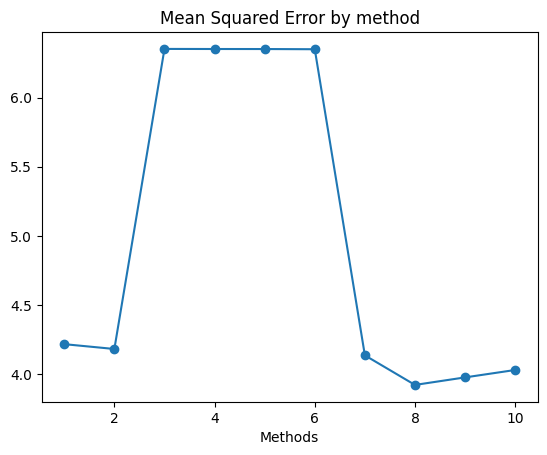

In [34]:
plt.plot(list(range(1,len(MSE)+1)), MSE, marker="o")
plt.title("Mean Squared Error by method")
plt.xlabel("Methods")